In [24]:
# Standard Libraries
import pandas as pd
import numpy as np
import os

# For visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data-Prep
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Model Buidling and metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
from sklearn.model_selection import cross_val_score

In [25]:
data = pd.read_csv("customer_booking.csv", encoding='latin-1')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

# **Data Preprocessing**

In [27]:
data.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [28]:
data.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [29]:
# Separating categorical and numerical columns
data_categorical = data.select_dtypes(include="object")
data_numerical = data.select_dtypes(exclude="object")

In [30]:
data_categorical.head()

,sales_channel,trip_type,flight_day,route,booking_origin
0,Internet,RoundTrip,Sat,AKLDEL,New Zealand
1,Internet,RoundTrip,Sat,AKLDEL,New Zealand
2,Internet,RoundTrip,Wed,AKLDEL,India
3,Internet,RoundTrip,Sat,AKLDEL,New Zealand
4,Internet,RoundTrip,Wed,AKLDEL,India


In [31]:
for col in data_categorical:
    print(data_categorical[col].value_counts())
    print("\n")

sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64


trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64


flight_day
Mon    8102
Wed    7674
Tue    7673
Thu    7424
Fri    6761
Sun    6554
Sat    5812
Name: count, dtype: int64


route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64


booking_origin
Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64




# **OneHotEncdoing**

In [32]:
data_categorical.columns

Index(['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin'], dtype='object')

In [33]:
columns = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
for value in columns:
    data_categorical=pd.get_dummies(data_categorical, columns=[value],drop_first=True)

In [34]:
data_categorical.shape

(50000, 910)

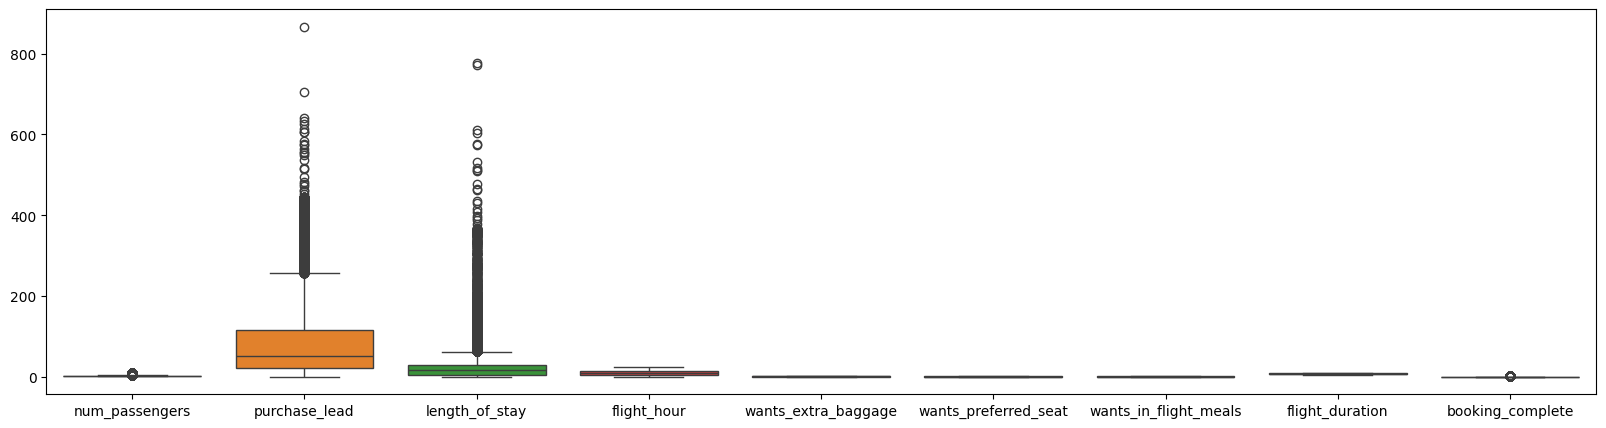

In [35]:
# Plotting boxplot for detecting outliers
plt.figure(figsize=(20,5))
sns.boxplot(data = data_numerical)
plt.show()

In [36]:
# Replacing outliers with median
#function to return a list of index of outliers
column_list = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration']
for feature in column_list:
    Q1= data_numerical[feature].quantile(0.25)
    Q3 =data_numerical[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    median = data_numerical[feature].median()

    data_numerical[feature] = np.where(data_numerical[feature]< lower_limit, median,data_numerical[feature])
    data_numerical[feature] = np.where(data_numerical[feature]> upper_limit, median,data_numerical[feature])

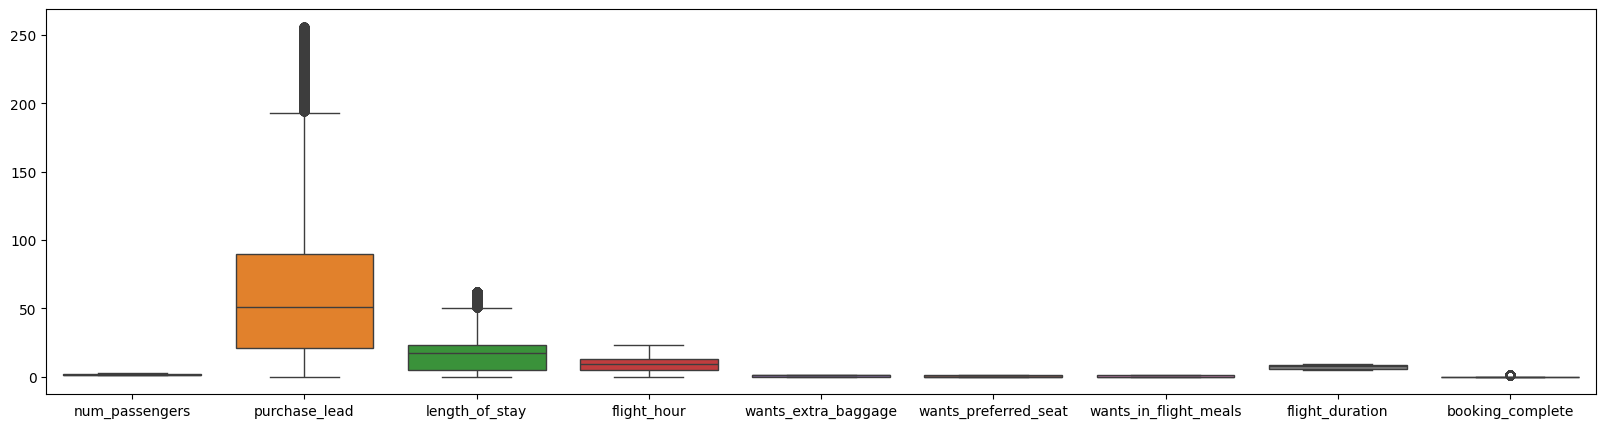

In [37]:
# Plotting boxplot for detecting outliers
plt.figure(figsize=(20,5))
sns.boxplot(data = data_numerical)
plt.show()

# **Feature Scaling**

In [38]:
# combining numerical and categorical column data
df = pd.concat([data_categorical,data_numerical], axis =1)

In [39]:
# Separating dependent and independent variables
X = df.drop(["booking_complete"] , axis=1)
y = df["booking_complete"]

In [40]:
# Using StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [41]:
X_scaled = pd.DataFrame(X_scaled)

In [42]:
y.value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [43]:
# using imblearn to removing imablance in our dataset
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_scaled, y)
print(x_smote.shape)
print(y_smote.shape)

(85044, 918)
(85044,)


# **EDA**

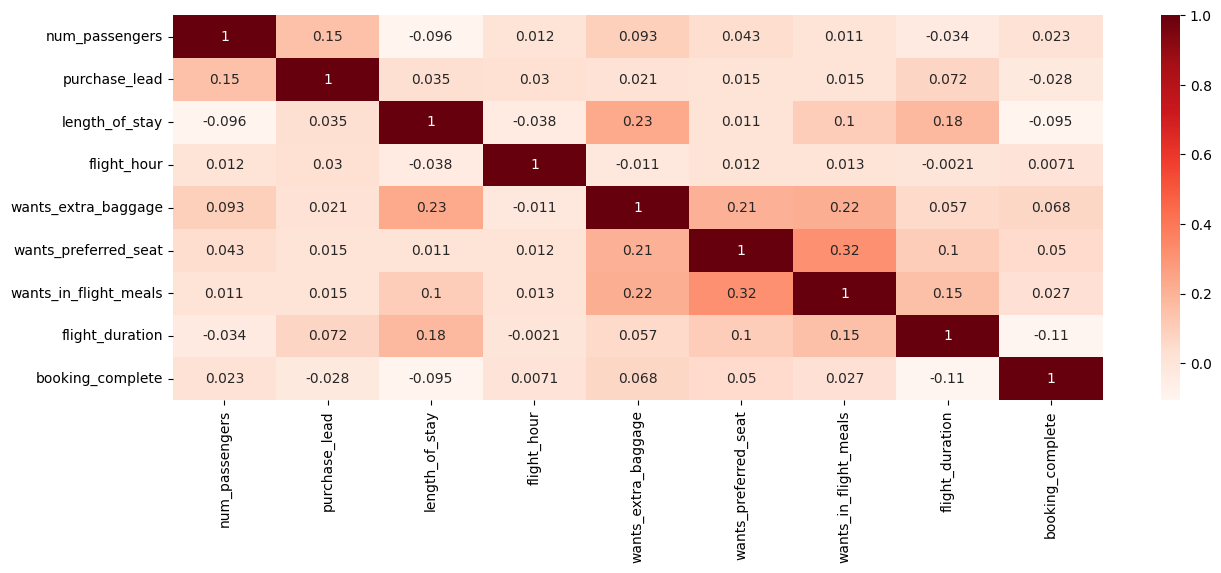

In [44]:
# Plotting heatmap
plt.figure(figsize=(15,5))
sns.heatmap(data_numerical.corr() , annot=True, cmap="Reds")
plt.show()

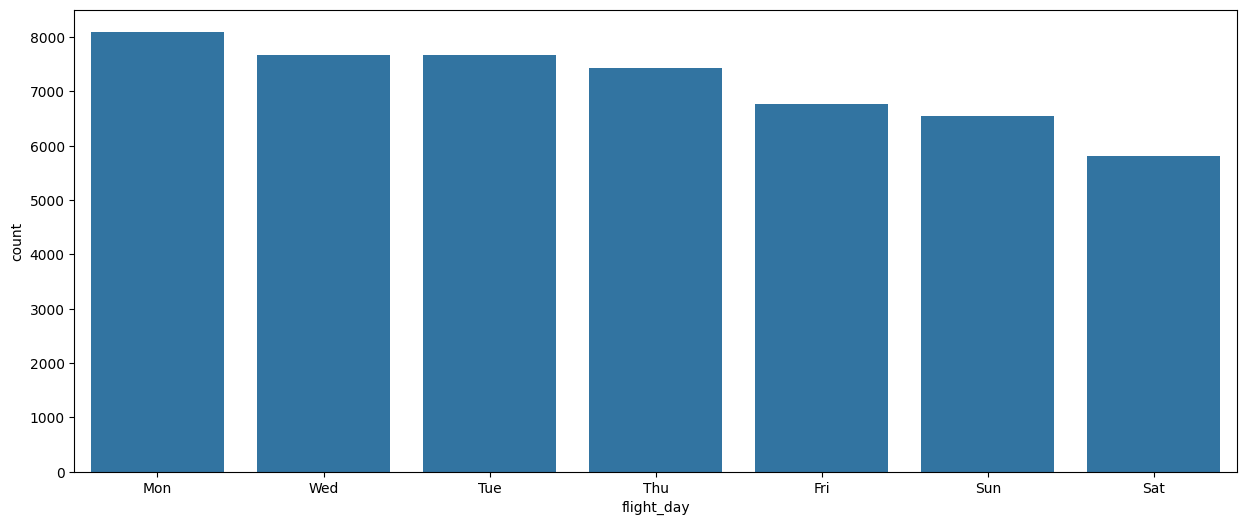

In [45]:
# No. of flights on each day of the week
plt.figure(figsize=(15,6))
sns.countplot(x = "flight_day", data=data, order=data["flight_day"].value_counts().index)
plt.show()

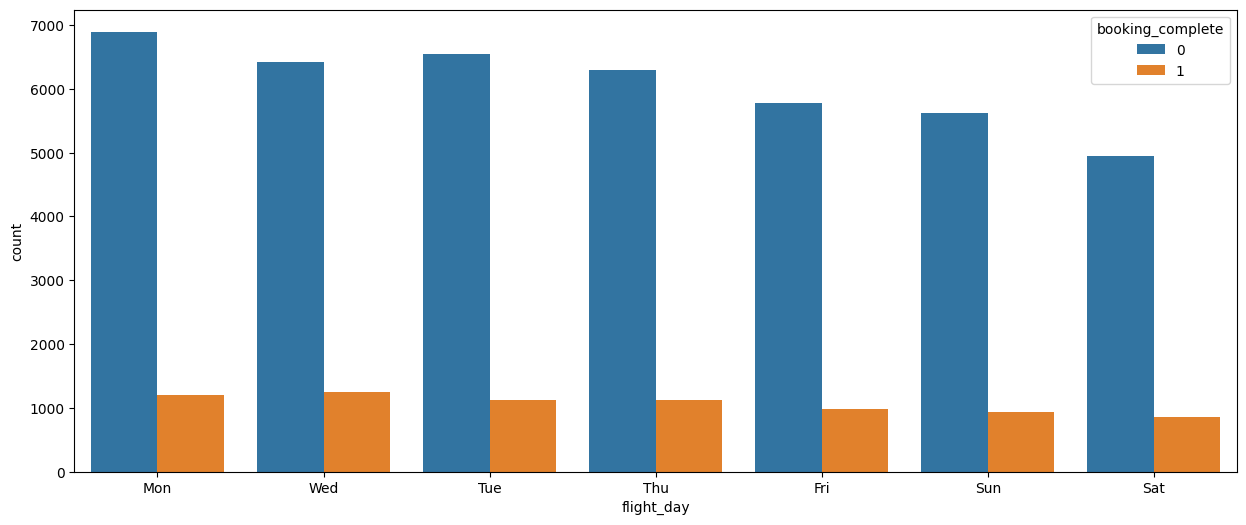

In [46]:
# No. of flights on each day of the week
plt.figure(figsize=(15,6))
sns.countplot(x = "flight_day",hue = "booking_complete", data=data, order=data["flight_day"].value_counts().index)
plt.show()

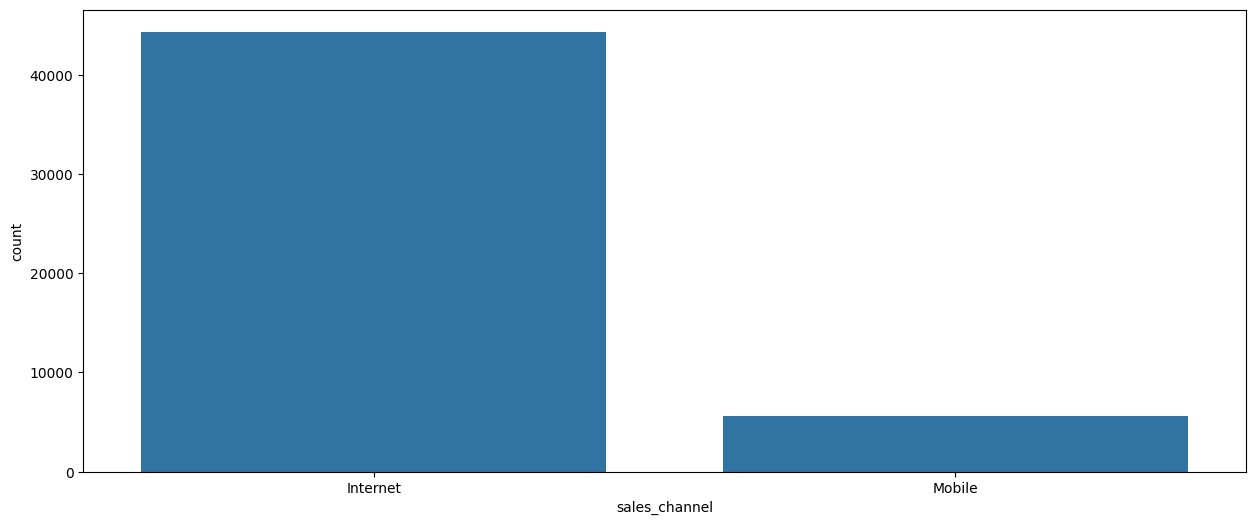

In [47]:
# Frequently used Booking channel
plt.figure(figsize=(15,6))
sns.countplot(x = "sales_channel", data=data, order=data["sales_channel"].value_counts().index)
plt.show()

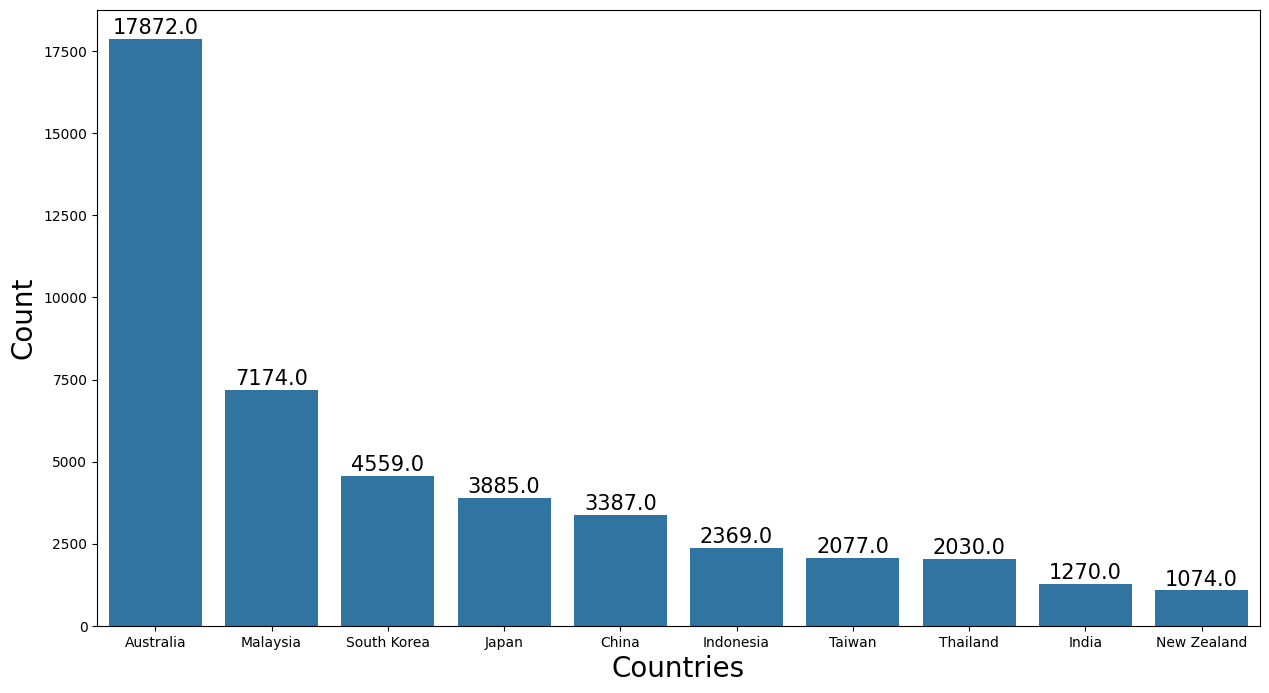

In [48]:
# Top 10 Countries in flight bookings
plt.figure(figsize=(15,8))
plots = sns.countplot(x="booking_origin",  data=data ,order=data.booking_origin.value_counts().iloc[:10].index)
plt.xlabel("Countries",fontsize= 20)
plt.ylabel("Count", fontsize= 20)

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()),
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')

# **Top 10 Countries**

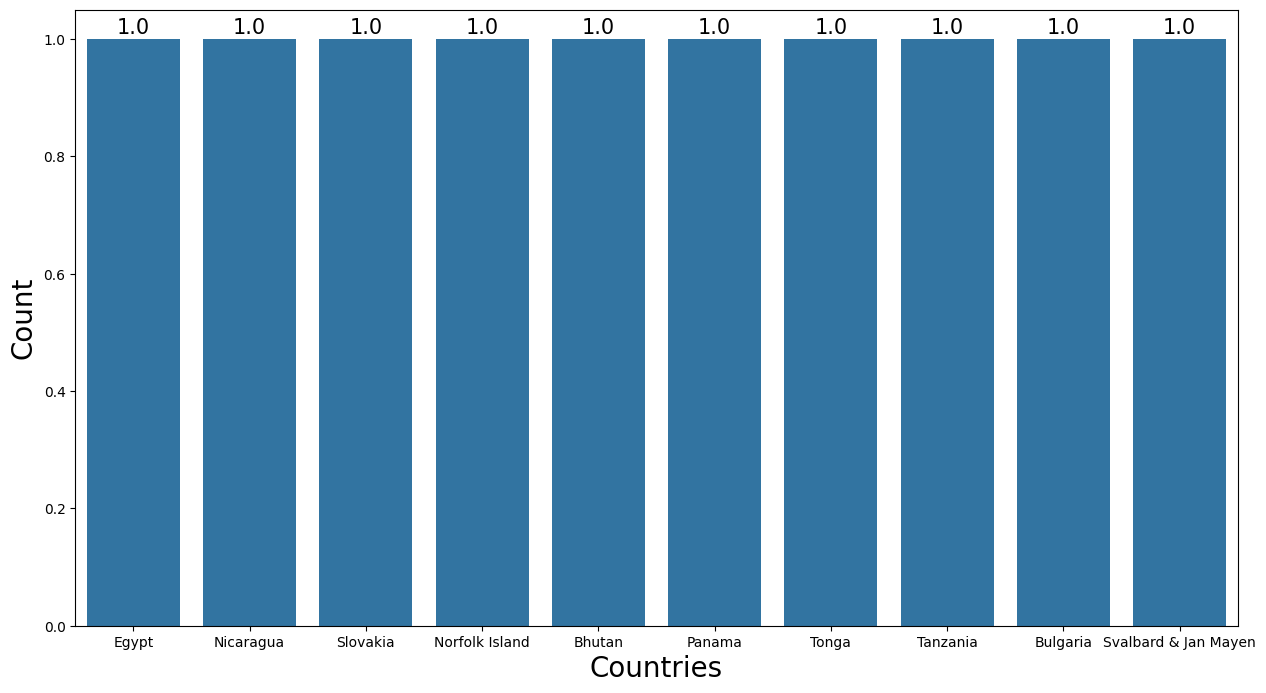

In [49]:
# Bottom 10 Countries in flight bookings
plt.figure(figsize=(15,8))
plots = sns.countplot(x="booking_origin",  data=data ,order=data.booking_origin.value_counts().iloc[-10:].index)
plt.xlabel("Countries",fontsize= 20)
plt.ylabel("Count", fontsize= 20)

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()),
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')

# **Cross Validation**

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x_smote,y_smote, test_size=0.25,random_state=101)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(63783, 918)
(21261, 918)
(63783,)
(21261,)


In [51]:
# using random forest classifier
rforest = RandomForestClassifier()
rforest.fit(x_train, y_train)

RandomForestClassifier()

In [52]:
y_pred_rf_train = rforest.predict(x_train)
y_pred_rf_test = rforest.predict(x_test)

In [53]:
# Using K-FOLD method by using cross_val_score
accuracy = cross_val_score(rforest, x_train, y_train, cv=10)

In [54]:
accuracy

array([0.91519047, 0.91895281, 0.92067722, 0.91423644, 0.91517717,
       0.91407965, 0.92677955, 0.91658827, 0.91831295, 0.91831295])